In [1]:
# Erasmus+ ICCT project (2018-1-SI01-KA203-047081)

# Toggle cell visibility

from IPython.display import HTML
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide()
    } else {
        $('div.input').show()
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Promijeni vidljivost <a href="javascript:code_toggle()">ovdje</a>.''')
display(tag)

# Hide the code completely

# from IPython.display import HTML
# tag = HTML('''<style>
# div.input {
#     display:none;
# }
# </style>''')
# display(tag)

In [2]:
%matplotlib notebook
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import Image, YouTubeVideo

## Sustav za kontrolu razine vode

Primjer vrlo jednostavnog sustava za kontrolu razine vode shematski je prikazan na slici ispod (lijevo). Cilj ovog upravljačkog sustava je održavati referentnu (željenu) razinu vode u spremniku. Željena razina vode $H_{ref}$ također predstavlja i ulazni signal za blok-dijagram prikazan na slici dolje (desno).
Položaj zapornog ventila može se promijeniti ako se plovak pomakne ili ako se promijeni položaj matice na vretenu. Položaj matice na vretenu je povezan s $H_{ref}$, a položaj plovka je, naravno, povezan s razinom vode $H$. Poluga transformira razliku između ova dva signala u pomicanje (otvaranje) zapornog ventila. Izlaz zapornog ventila predstavlja ulazni protok $Q_{in}$. Smatra se da je otvaranje regulacijskog ventila izvan kontrole sustava i stoga se označava kao smetnja $d$. To naravno utječe na odljev $Q_{out}$. Signali $Q_{in}$ i $Q_{out}$ predstvaljaju ulaze u spremnik. Izlazni signal spremnika je razina vode $H$ što je ujedno i izlazni signal cijelog sustava. Plovak, koji se koristi za mjerenje izlaznog signala sustava, predstavlja takozvanu povratnu vezu, jer se koristi za usporedbu referentne (željene) razine vode $H_{ref}$ sa stvarnom razinom vode $H$.



<br>
<br>

<table>
    <tr>
        <th>Shematski prikaz sustava za kontrolu razine vode</th>
        <th>Blok-dijagram sustava za kontrolu razine vode</th>
    </tr>
    <tr>
        <td><img src='img/water-level-schematic_hr.png'></td>
        <td><img src='img/water-level-block-diagram_hr.png'></td>
    </tr>
</table>

---

### Kako koristiti ovaj interaktivni primjer?

- Upotrijebite klizače za promjenu vrijednosti željene razine vode ($H_{ref}$), proporcionalnog koeficijenta podešavanja ($K_p$) i odljeva ($Q_{out}$).

In [3]:
h_ = 5 # water level

A = 12000 # area of water tank
Tv = 400 # time discretisation for z-transform

# geometry
x_min = -15
x_max = 60
y_min = -10
y_max = 55
h_tank = 20
l_tank = 37
l_whole_tank = 40
d_pipe = 2
h_ventil = 5
l_ventil = 4
l_pipe1 = 6
l1_pipe2 = 9
l2_pipe2 = 4
l_pipe3 = 6
l_podpore = 5
h_podpore = 4

In [4]:
# lists of points for plot

rob_x = np.array([x_min, x_max, x_max, x_min, x_min])
rob_y = np.array([y_min, y_min, y_max, y_max, y_min])

tank_x = np.array([0, 0, l_whole_tank, l_whole_tank, l_tank, l_tank])
tank_y = np.array([h_tank, 0, 0, d_pipe, d_pipe, h_tank])

ventil_x = np.array([0, l_ventil, l_ventil, 0, 0])
ventil_y = np.array([(h_ventil - d_pipe) / 2, 
                     -(d_pipe + (h_ventil - d_pipe) / 2), (h_ventil - d_pipe) / 2,
                     -(d_pipe + (h_ventil - d_pipe) / 2),
                     (h_ventil - d_pipe) / 2])

pipe1_x = np.array([-l_pipe1, 0, 0, -l_pipe1])
pipe1_y = np.array([0, 0, -d_pipe, -d_pipe])

pipe2_x = np.array([l1_pipe2, l1_pipe2, 0, 0, l1_pipe2 - d_pipe,
                   l1_pipe2 - d_pipe])
pipe2_y = np.array([-l2_pipe2, 0, 0, -d_pipe, -d_pipe, -l2_pipe2])

pipe3_x = np.array([l_pipe3, 0, 0, l_pipe3])
pipe3_y = np.array([0, 0, -d_pipe, -d_pipe])

podpora_x = np.array([-(1/2+1/5)*l_podpore, -1/2*l_podpore, -1/4*l_podpore,
                      -(1/4+1/5)*l_podpore, -1/4*l_podpore, 0, -1/5*l_podpore,
                      0, 1/4*l_podpore, (1/4-1/5)*l_podpore, 1/4*l_podpore,
                      0, -1/4*l_podpore, 1/2*l_podpore, (1/2-1/5)*l_podpore])
podpora_y = np.array([-h_podpore, -3/4*h_podpore, -3/4*h_podpore,
                      -h_podpore, -3/4*h_podpore, -3/4*h_podpore, -h_podpore,
                      -3/4*h_podpore, -3/4*h_podpore, -h_podpore, -3/4*h_podpore,
                      0, -3/4*h_podpore, -3/4*h_podpore, -h_podpore])

t_x=np.array([])

<IPython.core.display.Javascript object>


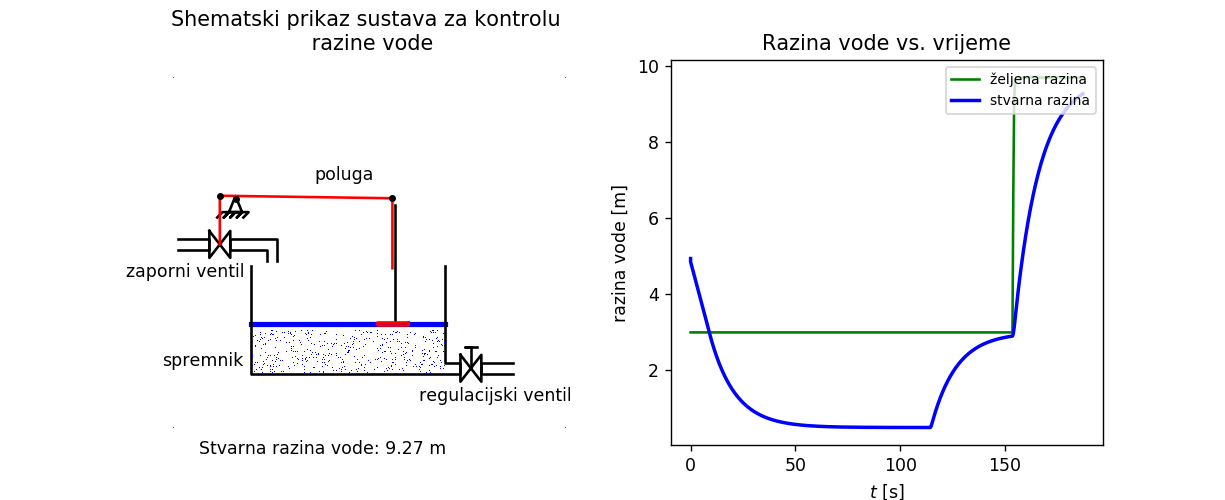

In [5]:
fig = plt.figure(figsize=(9.8, 4), num="Sustav za kontrolu razine vode")
ax = fig.add_subplot(1, 2, 1)
ax.set_axis_off()
graph = fig.add_subplot(1, 2, 2)
list_h_x =[]
list_h_y = []
list_h_desired_x = []
list_h_desired_y = []


q_out = 1
q_out_prev = q_out
h_desired =5
h_desired_prev = h_desired
h_ = h_desired
h_prev = h_
K = 1

# create slider widgets:
set_h_desired = widgets.FloatSlider(value=3.,min=0.0,max=10,step=.1,description=r'\(H_{ref}\) [m]',
                    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.2f')
set_K = widgets.FloatSlider(value=.1,min=0.,max=.5,step=0.01,description=r'\(K_p \)',
                    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.2f')
set_q_out = widgets.FloatSlider(value=2.5,min=0.,max=5.,step=0.1,description=r'\(Q_{out} \) [m<sup>3</sup>/s]',
                    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.2f')

vbox1 = widgets.VBox([set_h_desired, set_K, set_q_out])
display(vbox1)

def set_coefficients(set_h_desired, set_K, set_q_out):
    global K, h_desired, q_out
    K = set_K.value
    h_desired = set_h_desired.value
    q_out = set_q_out.value

#interact(set_coefficients, set_h_desired=(0, 15.), set_K=(0., 5., 0.1), set_q_out=(0, 5.))

def update_figure(i):
    global h_prev, h_desired_prev, q_out_prev, h_
    set_coefficients(set_h_desired, set_K, set_q_out)

    d = 33 - h_desired
    x = K*(27-(-8 + l_ventil / 2))/(K+1) #za podporo
    
    # functions for calculating new height
    def calculate_new_height(K, h_prev, h_desired, h_desired_prev, q_out, q_out_prev):
        # z-transform (h_)
        K = K*10 # for faster response
        temp_result = - h_prev * (K - A * 2 / Tv) + h_desired * K + h_desired_prev * K - q_out - q_out_prev
        return temp_result / (A * 2 / Tv + K)
    def calculate_new_height_negative(h_prev, q_out, q_out_prev):
        # calculated, if desired height is lower than current height
        temp_result = - h_prev * (- A * 2 / Tv) - q_out - q_out_prev
        return temp_result / (A * 2 / Tv)

    if h_desired < h_:
        h_ = calculate_new_height_negative(h_prev, q_out, q_out_prev)
    else:
        h_ = calculate_new_height(K, h_prev, h_desired, h_desired_prev, q_out, q_out_prev)
    
    if (h_<0):
        h_ = 0

    vzvod1_x = np.array([27.5, 27.5])
    vzvod1_y = np.array([h_, h_ + 22])

    vzvod2_x = np.array([27, 27, -8 + l_ventil / 2,
                         -8 + l_ventil / 2])
    vzvod2_y = np.array([h_ + d - 13, h_ + d, -(-33 + (h_ + d)) * K + 33,
                         h_tank + 5 - d_pipe / 2])

    # lists for water drops plot
    koef_in_drops=int((h_desired-h_)*K*5*3)
    if (koef_in_drops<0):
        koef_in_drops = 0
    drops_in_x = np.array([random.randint(-10, 10)/12 for i in range(koef_in_drops)])
    drops_in_y = np.array([random.randint(-10, 10)/2 for i in range(koef_in_drops)])
    
    koef_out_drops = int(q_out*3*5)
    if h_ == 0:
        koef_out_drops = int((h_desired)*K*5*3)
    drops_out_x = np.array([random.randint(-10,10)/4 for i in range(koef_out_drops)])
    drops_out_y = np.array([random.randint(-10, 10)/10 for i in range(koef_out_drops)])

    drops_tank = int(h_)*50
    drops_tank_x = np.array([random.randint(0, 370)/10 for i in range(drops_tank)])
    drops_tank_y = np.array([random.randint(0, int(h_-1)*10)/10 for i in range(drops_tank)])

    plovec_x = np.array([3, 3, -3, -3, 3])
    plovec_y = np.array([0.3, -0.3, -0.3, 0.3, 0.3])
            
    # plot
    ax.clear()
    ax.plot(rob_x, rob_y, ',')
    ax.plot([0, l_tank], [h_, h_], 'b', lw=3)
    ax.plot(tank_x, tank_y, 'k')
    ax.plot(ventil_x + l_whole_tank, ventil_y + d_pipe, 'k')
    ax.plot(pipe1_x - 8, pipe1_y + h_tank + 5, 'k')
    ax.plot(pipe2_x + l_ventil - 8, pipe2_y + h_tank + 5, 'k')
    ax.plot(ventil_x - 8, ventil_y + h_tank + 5, 'k')
    ax.plot(pipe3_x + l_whole_tank + l_ventil, pipe3_y + d_pipe, 'k')
    ax.plot(podpora_x - 8 + l_ventil / 2 + x, podpora_y + 33, 'k')
    ax.plot(vzvod2_x, vzvod2_y, 'r')
    ax.plot(vzvod1_x, vzvod1_y, 'k')
    ax.plot(plovec_x + 27, plovec_y + h_, 'r')
    ax.plot(drops_in_x + l_ventil - 8 + l1_pipe2 - d_pipe / 2, drops_in_y + h_tank + 5 - l2_pipe2 - 7, 'b.')
    ax.plot(drops_out_x + l_whole_tank + l_ventil + l_pipe3 + 4, drops_out_y + d_pipe / 2, 'b.')
    ax.plot(drops_tank_x, drops_tank_y, 'b,')
    ax.plot([27, -8+l_ventil/2, -8+l_ventil/2+x], [h_ + d, -(-33 + (h_ + d))*K + 33, 33-0.5], 'k.')
    ax.plot(np.array([2,2,0.8,3.2]) + l_whole_tank, np.array([-1,3,3,3]) + d_pipe, 'k') # add "T" to the output valve

    list_h_x.append(i*Tv/1000)
    list_h_y.append(h_)
    list_h_desired_x.append(i*Tv/1000)
    list_h_desired_y.append(h_desired)
    graph.clear()
    graph.plot(list_h_desired_x, list_h_desired_y, 'g', label='željena razina')
    graph.plot(list_h_x, list_h_y, 'b', lw=2, label='stvarna razina')
     
    ax.set_title('Shematski prikaz sustava za kontrolu \n razine vode')
    ax.text(-17, 1.5, 'spremnik')
    ax.text(32, -5, 'regulacijski ventil')
    ax.text(-24, 18, 'zaporni ventil')
    ax.text(12, 36, 'poluga')
    ax.text(-10, -15, 'Stvarna razina vode: %.2f m' %h_)
    ax.set_axis_off()
    graph.set_xlabel('$t$ [s]')
    graph.set_ylabel('razina vode [m]')
    graph.set_title('Razina vode vs. vrijeme')
    graph.legend(loc=1, fontsize=8)
    
    h_prev = h_
    h_desired_prev = h_desired
    q_out_prev = q_out 
    
    
ani = animation.FuncAnimation(fig, update_figure, interval=Tv)
